<a href="https://colab.research.google.com/github/VIVEKGANGA/model-factory/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim import Adam


In [2]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    # 3 input image channel, 6 output
    # 5 * 5 kernal
    self.cn1 = nn.Conv2d(3, 6, 5)  #Output shape = 32 - 5 = 27 : [6, 28, 28]
    # 3 input image channel, 6 output
    # feature maps and 5x5 conv kernel
    self.cn2 = nn.Conv2d(6, 16, 5)
    # fully connected layers of size 120, 84 and 10
    self.fc1 = nn.Linear( 16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):
    x = F.relu(self.cn1(x)) # Output Shape: [6, 28, 28]
    x =F.max_pool2d(x, 2, 2) # Output Shape: [6, 14, 14]
    x = F.relu(self.cn2(x)) # Output Shape : [16, 10, 10]
    x = F.max_pool2d(x, 2, 2) # Output Shape : [16, 5, 5]
    x = torch.flatten(x, 1) # Output Shape : [bs, 400]
    x = F.relu(self.fc1(x)) # Output Shape : [bs, 84]
    x = F.relu(self.fc2(x)) # Output Shape : [bs, 10]
    x = self.fc3(x)
    return x

In [3]:
lenet = LeNet()
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [12]:
def train(train_dataloader, model, device, optimizer, epoch):
  model.train()
  total_loss = 0
  for i, (X, y) in enumerate(train_dataloader):
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    pred = model(X)
    loss = nn.CrossEntropyLoss()(pred, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    if (i+1) % 1000 == 0:
      print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %(epoch + 1, i + 1, total_loss / 200))
      total_loss = 0.0



def test(test_dataloader, model, device):
  success = 0
  counter = 0
  model.eval()
  with torch.no_grad():
    for i, (X, y) in enumerate(test_dataloader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      pred_value, pred_label = torch.max(pred, axis=1)
      counter += y.size(0)
      success += (pred_label == y).sum().item()
  print('LeNet accuracy on 10000 images from test dataset: %d %%' % (
        100 * success / counter))


In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # This transforms pixel values from [0.0, 1.0] → [-1.0, 1.0]
])

train_dataset = torchvision.datasets.CIFAR10(root='/data', train=True, download=True, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset = torchvision.datasets.CIFAR10(root='/data', train=False, download=True, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


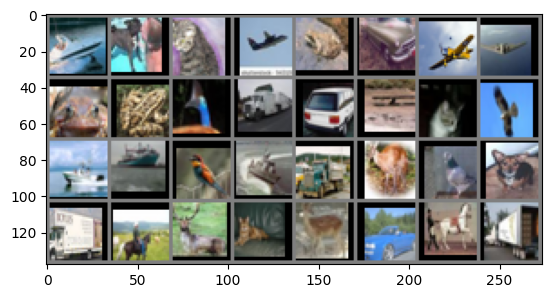

In [6]:
def imshow(image):
  image = image/2 + 0.5
  npimage = image.numpy()
  plt.imshow(np.transpose(npimage, (1 ,2, 0)))
  plt.show()

train_sample = next(iter(train_dataloader))
images, labels = train_sample
imshow(torchvision.utils.make_grid(images))


In [13]:
# define optimizer
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
lenet.to(device)

# training loop over the dataset multiple times
for epoch in range(5):
    train(train_dataloader,lenet,device,optim,epoch)
    test(test_dataloader,lenet, device)

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 6.751
LeNet accuracy on 10000 images from test dataset: 55 %
[Epoch number : 2, Mini-batches:  1000] loss: 6.523
LeNet accuracy on 10000 images from test dataset: 56 %
[Epoch number : 3, Mini-batches:  1000] loss: 6.311
LeNet accuracy on 10000 images from test dataset: 58 %
[Epoch number : 4, Mini-batches:  1000] loss: 6.105
LeNet accuracy on 10000 images from test dataset: 58 %
[Epoch number : 5, Mini-batches:  1000] loss: 5.872
LeNet accuracy on 10000 images from test dataset: 60 %
Finished Training


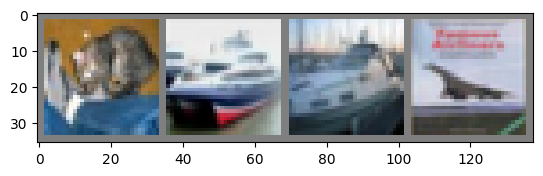

Label:           3     8     8     0
Predicted:       3     8     8     0


In [16]:
test_sample = next(iter(test_dataloader))
image, label = test_sample
imshow(torchvision.utils.make_grid(image[:4]))
print('Label:      ', ' '.join('%5s' % label[j].item() for j in range(4)))

output = lenet(image.to(device))
_, predicted = torch.max(output, 1)
print('Predicted:  ', ' '.join('%5s' % predicted[j].item() for j in range(4)))
